<a href="https://colab.research.google.com/github/zianlin/beverage-predictor/blob/main/predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
import copy
import statistics
import random
import string
import scipy
import numpy as np
import dateutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import sklearn
from collections import defaultdict
from collections import Counter
from sklearn import linear_model
from sklearn.linear_model import Ridge
import csv
import math
from numpy import dot
from numpy.linalg import norm

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#**Q1**

In [ ]:
dataset = []
for i in range(2025995):
  dataset.append({})
i = 0
x = gzip.open("cellartracker (2).txt.gz")
for l in x:
  boolean = False
  for x in [b'wine/name', b'wine/wineId', b'wine/variant', b'wine/year', b'review/points', b'review/time', b'review/userId', b'review/userName', b'review/text']:
    if l.startswith(x): 
      dataset[i][str(x)[2:-1]] = str(l).split(':', 1)[1][1:-3]
      boolean = True
  if boolean: continue
  else: i = i + 1
  if i%100000 == 0: print(i)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


In [ ]:
dataset[0]

{'review/points': '96',
 'review/text': 'Olive, horse sweat, dirty saddle, and smoke. This actually got quite a bit more spicy and expressive with significant aeration. This was a little dry on the palate first but filled out considerably in time, lovely, loaded with tapenade, leather, dry and powerful, very black olive, meaty. This improved considerably the longer it was open. A terrific bottle of 1981, 96+ and improving. This may well be my favorite vintage of Beau except for perhaps the 1990.',
 'review/time': '1160179200',
 'review/userId': '1',
 'review/userName': 'Eric',
 'wine/name': '1981 Ch&#226;teau de Beaucastel Ch&#226;teauneuf-du-Pape',
 'wine/variant': 'Red Rhone Blend',
 'wine/wineId': '18856',
 'wine/year': '1981'}

In [ ]:
len(dataset)

2025995

In [ ]:
#pruning - remove NAs
temp = []
for d in dataset:
  if 'N/A' in [d[s] for s in ['wine/name', 'wine/wineId', 'wine/variant', 'wine/year', 'review/points', 'review/time', 'review/userId', 'review/userName', 'review/text']]:
    continue
  if int(d['review/time']) >= 0:
    temp.append(d)

dataset = temp
len(dataset)

1521507

In [ ]:
#pruning - remove reviews with less than 50 words
temp = []
for d in dataset:
  if len(d['review/text'].split()) < 50:
    continue
  temp.append(d)

dataset = temp
len(dataset)

399359

In [ ]:
lengths = [len(winesPerUser[d['review/userId']]) for u in winesPerUser]
statistics.mean(lengths)

In [ ]:
dataset.sort(key=lambda x: x['review/time'])

In [ ]:
points = []
for d in dataset:
  points.append(int(d['review/points']))

In [ ]:
statistics.mean(points)

89.66444226873566

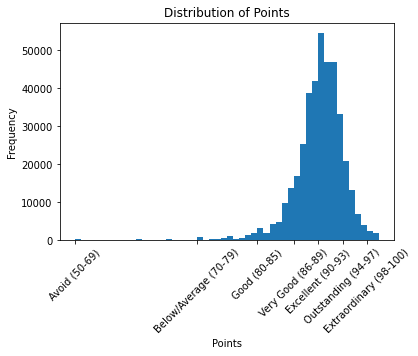

In [ ]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)

plt.hist(points, bins = 50)
plt.xticks([50, 70, 80, 86, 90, 94, 98], ["Avoid (50-69)", "Below/Average (70-79)", "Good (80-85)", "Very Good (86-89)", "Excellent (90-93)", "Outstanding (94-97)", "Extraordinary (98-100)"], rotation='45')
plt.gca().set(title='Distribution of Points', xlabel = 'Points', ylabel='Frequency');

##**Q2**

In [ ]:
def getMSE(list1, list2):
  return sum([(int(yp) - int(yt))**2 for (yp,yt) in zip(list1, list2)]) / len(list2)

In [ ]:
def getRMSE(list1, list2):
  return MSE(list1, list2)**0.5

In [ ]:
#stopwords
s = nltk.corpus.stopwords.words("english")
datastop = []
for d in dataset:
  d2 = copy.deepcopy(d)
  text = "".join([word + " " for word in dataset[0]['review/text'].split() if word not in s])
  d2['review/text'] = text
  datastop.append(d2)

In [ ]:
dataset[0]['review/text'], datastop[0]['review/text']

('Olive, horse sweat, dirty saddle, and smoke. This actually got quite a bit more spicy and expressive with significant aeration. This was a little dry on the palate first but filled out considerably in time, lovely, loaded with tapenade, leather, dry and powerful, very black olive, meaty. This improved considerably the longer it was open. A terrific bottle of 1981, 96+ and improving. This may well be my favorite vintage of Beau except for perhaps the 1990.',
 'Olive, horse sweat, dirty saddle, smoke. This actually got quite bit spicy expressive significant aeration. This little dry palate first filled considerably time, lovely, loaded tapenade, leather, dry powerful, black olive, meaty. This improved considerably longer open. A terrific bottle 1981, 96+ improving. This may well favorite vintage Beau except perhaps 1990. ')

In [ ]:
#stemming
ps = PorterStemmer()
datastem = []
for d in dataset:
  d2 = copy.deepcopy(d)
  text = "".join([ps.stem(word) + " " for word in dataset[0]['review/text'].split()])
  d2['review/text'] = text
  datastem.append(d2)

In [ ]:
dataset[0]['review/text'], datastem[0]['review/text']

('Olive, horse sweat, dirty saddle, and smoke. This actually got quite a bit more spicy and expressive with significant aeration. This was a little dry on the palate first but filled out considerably in time, lovely, loaded with tapenade, leather, dry and powerful, very black olive, meaty. This improved considerably the longer it was open. A terrific bottle of 1981, 96+ and improving. This may well be my favorite vintage of Beau except for perhaps the 1990.',
 'olive, hors sweat, dirti saddle, and smoke. thi actual got quit a bit more spici and express with signific aeration. thi wa a littl dri on the palat first but fill out consider in time, lovely, load with tapenade, leather, dri and powerful, veri black olive, meaty. thi improv consider the longer it wa open. A terrif bottl of 1981, 96+ and improving. thi may well be my favorit vintag of beau except for perhap the 1990. ')

In [ ]:
#both stopping and stemming
ps = PorterStemmer()
databoth = []
for d in datastop:
  d2 = copy.deepcopy(d)
  text = "".join([ps.stem(word) + " " for word in datastop[0]['review/text'].split()])
  d2['review/text'] = text
  databoth.append(d2)

In [ ]:
dataset[0]['review/text'], databoth[0]['review/text']

('Olive, horse sweat, dirty saddle, and smoke. This actually got quite a bit more spicy and expressive with significant aeration. This was a little dry on the palate first but filled out considerably in time, lovely, loaded with tapenade, leather, dry and powerful, very black olive, meaty. This improved considerably the longer it was open. A terrific bottle of 1981, 96+ and improving. This may well be my favorite vintage of Beau except for perhaps the 1990.',
 'olive, hors sweat, dirti saddle, smoke. thi actual got quit bit spici express signific aeration. thi littl dri palat first fill consider time, lovely, load tapenade, leather, dri powerful, black olive, meaty. thi improv consider longer open. A terrif bottl 1981, 96+ improving. thi may well favorit vintag beau except perhap 1990. ')

In [ ]:
train, temp = sklearn.model_selection.train_test_split(dataset, train_size=0.8, shuffle=True)
test, validation = sklearn.model_selection.train_test_split(temp, train_size=0.5, shuffle=False)

trainstop, tempstop = sklearn.model_selection.train_test_split(datastop, train_size=0.8, shuffle=True)
teststop, validationstop = sklearn.model_selection.train_test_split(temp, train_size=0.5, shuffle=False)

trainstem, tempstem = sklearn.model_selection.train_test_split(datastem, train_size=0.8, shuffle=True)
teststem, validationstem = sklearn.model_selection.train_test_split(temp, train_size=0.5, shuffle=False)

trainboth, tempboth = sklearn.model_selection.train_test_split(databoth, train_size=0.8, shuffle=True)
testboth, validationboth = sklearn.model_selection.train_test_split(temp, train_size=0.5, shuffle=False)

In [ ]:
#baseline 1
for t in [train, trainstop, trainstem, trainboth]:
  trainpoints = [int(d['review/points']) for d in t]
  means = [statistics.mean(trainpoints)]*len(trainpoints)
  print(getMSE(trainpoints, means))

16.557287150963887
16.515094510887767
16.589795515936487
16.569835392363384


In [ ]:
#baseline 2
for t in [(train, temp), (trainstop, tempstop), (trainstem, tempstem), (trainboth, tempboth)]:
  Xtrain = [[1, int(d['wine/year']), int(d['review/time']), len(d['review/text'])] for d in t[0]]
  Ytrain = [int(d['review/points']) for d in t[0]]
  Xtest = [[1, int(d['wine/year']), int(d['review/time']), len(d['review/text'])] for d in t[1]]
  Ytest = [int(d['review/points']) for d in t[1]]
  mod = linear_model.LinearRegression()
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xtest)
  MSE = sum([(yp - yt)**2 for (yp,yt) in zip(Ypred, Ytest)]) / len(Ytest)
  print(MSE)

15.327049642736014
15.552496114049609
15.278382356506715
15.352080183253173


In [ ]:
#bag of words model

In [ ]:
nWords = 500
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000]

In [ ]:
t = (trainstop, tempstop, validationstop)
unigrams, bigrams = [], []
for d in t[0]:
  token = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  unigrams += token
  bigrams += ngrams(token, 2)

In [ ]:
unicom, bicom = Counter(unigrams).most_common(nWords), Counter(bigrams).most_common(nWords)

In [ ]:
combocom = Counter(unigrams+bigrams).most_common(nWords)

In [ ]:
def featureUni(d):
  v = [0]*nWords
  unigrams = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  for i in range(nWords):
    if unicom[i][0] in unigrams:
      v[i] = unigrams.count(unicom[i][0])
  return v

def featureBi(d):
  v = [0]*nWords
  bigrams = list(ngrams(d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split(), 2))
  for i in range(nWords):
    if bicom[i][0] in bigrams:
      v[i] = bigrams.count(bicom[i][0])
  return v

In [ ]:
def featureCombo(d):
  v = [0]*nWords
  unigrams = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  bigrams = list(ngrams(unigrams, 2))
  combograms = unigrams+bigrams
  for i in range(nWords):
    if combocom[i][0] in combograms:
      v[i] = combograms.count(combocom[i][0])
  return v

In [ ]:
#tf-idf
idfDict = defaultdict(int)
for u in unicom:
  count = 0
  for d in t[0]:
    #strip punctuation + lowercase
    text = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
    if u[0] in text: count += 1
  idfDict[u[0]] = math.log2(len(t[0])/(count))

In [ ]:
def tf(tx, d):
  unigrams = []
  text = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower()
  return text.split().count(tx)
def tfidf(tx, d):
  return tf(tx, d)*idfDict[tx]
def tfidfVec(d):
  v = [0]*nWords
  for i in range(nWords):
    v[i] = tfidf(unicom[i][0], d)
  return v

In [ ]:
#tfidf
Xtrain = [tfidfVec(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]

In [ ]:
Xtest = [tfidfVec(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]
Xvalid = [tfidfVec(d) for d in t[2]]
Yvalid = [d['review/points'] for d in t[2]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=l)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xvalid)
  print(getMSE(Ypred, Yvalid), l)

In [ ]:
#combograms first
Xtrain = [featureCombo(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]

In [ ]:
Xtest = [featureCombo(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]
Xvalid = [featureCombo(d) for d in t[2]]
Yvalid = [d['review/points'] for d in t[2]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=l)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xvalid)
  print(getMSE(Ypred, Yvalid), l)

11.982171474358974 0.01
11.982171474358974 0.1
11.982171474358974 1
11.981244991987179 10
11.979166666666666 100
11.973657852564102 1000
12.129056490384615 10000


In [ ]:
mod = Ridge(alpha=1000)
mod.fit(Xtrain,Ytrain)
Ypred = mod.predict(Xtest)
getMSE(Ypred, Ytest)

11.940104166666666

In [ ]:
#unigrams first
Xtrain = [featureUni(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]

IndexError: ignored

In [ ]:
Xtest = [featureUni(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]
Xvalid = [featureUni(d) for d in t[2]]
Yvalid = [d['review/points'] for d in t[2]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=l)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xvalid)
  print(getMSE(Ypred, Yvalid), l)

In [ ]:
mod = Ridge(alpha=100)
mod.fit(Xtrain,Ytrain)
Ypred = mod.predict(Xtest)
getMSE(Ypred, Ytest)

11.033866686698717

In [ ]:
#then bigrams
Xtrain = [featureBi(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]

In [ ]:
Xtest = [featureBi(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]
Xvalid = [featureUni(d) for d in t[2]]
Yvalid = [d['review/points'] for d in t[2]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=l)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xvalid)
  print(getMSE(Ypred, Yvalid), l)

20.027569110576923 0.01
20.027569110576923 0.1
20.026893028846153 1
20.021409254807693 10
19.971429286858974 100
19.570437700320515 1000
18.151442307692307 10000


In [ ]:
mod = Ridge(alpha=10000)
mod.fit(Xtrain,Ytrain)
Ypred = mod.predict(Xtest)
getMSE(Ypred, Ytest)

14.081505408653847

In [ ]:
##end

In [ ]:
t = (trainstop, tempstop)
unigrams, bigrams = [], []
for d in t[0]:
  token = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  unigrams += token
  bigrams += ngrams(token, 2)
unicom, bicom = Counter(unigrams).most_common(nWords), Counter(bigrams).most_common(nWords)
def featureUni(d):
  v = [0]*nWords
  unigrams = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  for i in range(nWords):
    if unicom[i][0] in unigrams:
      v[i] = unigrams.count(unicom[i][0])
  return v

def featureBi(d):
  v = [0]*nWords
  bigrams = ngrams(d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split(), 2)
  for i in range(nWords):
    if bicom[i][0] in bigrams:
      v[i] = bigrams.count(bicom[i][0])
  return v

In [ ]:
#unigrams first
Xtrain = [featureUni(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]
Xtest = [featureUni(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=1)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xtest)
  MSE = sum([(yp - yt)**2 for (yp,yt) in zip(Ypred, Ytest)]) / len(Ytest)
  print(MSE, l)

In [ ]:
#then bigrams
Xtrain = [featureBi(d) for d in t[0]]
Ytrain = [d['review/points'] for d in t[0]]
Xtest = [featureBi(d) for d in t[1]]
Ytest = [d['review/points'] for d in t[1]]

In [ ]:
for l in lambdas:
  mod = Ridge(alpha=1)
  mod.fit(Xtrain,Ytrain)
  Ypred = mod.predict(Xtest)
  MSE = sum([(yp - yt)**2 for (yp,yt) in zip(Ypred, Ytest)]) / len(Ytest)
  print(MSE, l)

In [ ]:
t = (trainstem, test)
unigrams, bigrams = [], []
for d in t[0]:
  token = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  unigrams += token
  bigrams += ngrams(token, 2)
unicom, bicom = Counter(unigrams).most_common(nWords), Counter(bigrams).most_common(nWords)
def featureUni(d):
  v = [0]*nWords
  unigrams = d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split()
  for i in range(nWords):
    if unicom[i][0] in unigrams:
      v[i] = unigrams.count(unicom[i][0])
  return v

def featureBi(d):
  v = [0]*nWords
  bigrams = ngrams(d['review/text'].translate(str.maketrans('', '', string.punctuation)).lower().split(), 2)
  for i in range(nWords):
    if bicom[i][0] in bigrams:
      v[i] = bigrams.count(bicom[i][0])
  return v

In [ ]:
#

In [ ]:
unigrams, bigrams = [], []
unigramDict, bigramDict = defaultdict(int), defaultdict(int)
punctuation = set(string.punctuation)

In [ ]:
#get all unigrams/bigrams
for d in train:
  for w in d['review/text'].split():
    w = ''.join([c for c in w.lower() if not c in punctuation])
    if w == '': continue
    unigrams.append(w)
bigrams = list(zip(unigrams[:-1], unigrams[1:]))

In [ ]:
#get frequency of all unigrams/bigrams + create combogram list for 1c
for u in unigrams: unigramDict[u] += 1

In [ ]:
for b in bigrams: bigramDict[b] += 1

In [ ]:
#get 1000 most common unigrams/bigrams
unigrams1k = Counter(unigramDict).most_common(500)
bigrams1k = Counter(bigramDict).most_common(500)

In [ ]:
def featureUni(d):
  v = [0]*500

  #get unigrams
  unigrams = []
  for w in d['review/text'].split():
    w = ''.join([c for c in w.lower() if not c in punctuation])
    if w == '': continue
    unigrams.append(w)

  for i in range(500):
    if unigrams1k[i][0] in unigrams:
      v[i] = unigrams.count(unigrams1k[i][0])
  return v

In [ ]:
Xtrain = [featureUni(d) for d in train]

In [ ]:
Ytrain = [d['rating'] for d in train]
Xtest = [featureUni(d) for d in test]
Ytest = [d['rating'] for d in test]

In [ ]:
mod = Ridge(alpha=1)
mod.fit(Xtrain,Ytrain)
Ypred = mod.predict(Xtest)
MSE = sum([(yp - yt)**2 for (yp,yt) in zip(Ypred, Ytest)]) / len(Ytest)

In [ ]:
theta = mod.coef_
weights = [(t, w[0]) for t, w in zip(theta, unigrams1k)]
weights.sort()

In [ ]:
times = [dateutil.parser.parse(d['date_added']) for d in dataset]

In [ ]:
datatimes = list(zip(dataset, times))

In [ ]:
datatimes.sort(key=lambda x: x[1])

In [ ]:
datatimes = datatimes[2:]

In [ ]:
datatimes[0]

({'book_id': '196084',
  'date_added': 'Mon Jan 01 00:00:00 -0800 2001',
  'date_updated': 'Thu Dec 17 03:12:11 -0800 2009',
  'n_comments': 0,
  'n_votes': 0,
  'rating': 3,
  'read_at': 'Sat Jan 06 00:00:00 -0800 2007',
  'review_id': 'd23dc89ab32cd864e54d18369751163b',
  'review_text': '"this was not a bad read. it was a little hokey at times ... the best example of that was the liberal use of the exclamation *i declare* by the southern female lead. and by liberal i mean about a thousand times. but that is likely attributed to the period\\',
  'started_at': '',
  'user_id': 'd889b42d9eb7b80e02f24830e27c6389'},
 datetime.datetime(2001, 1, 1, 0, 0, tzinfo=tzoffset(None, -28800)))

In [ ]:
timesSorted = []
for d in datatimes:
  timesSorted.append(d[1])

In [ ]:
ratingSorted = [d[0]['rating'] for d in datatimes]

In [ ]:
monthAverages = defaultdict(list)

for d in datatimes:
    t = d[1]
    monthAverages[t.month].append(d[0]['rating'])

for k in monthAverages:
    monthAverages[k] = sum(monthAverages[k]) / len(monthAverages[k])

In [ ]:
monthAverages

defaultdict(list,
            {1: 3.6761906932746773,
             2: 3.6883364673954224,
             3: 3.7009164067613876,
             4: 3.6926848869123425,
             5: 3.6930222649718862,
             6: 3.6931623400819773,
             7: 3.6582304492466275,
             8: 3.675094359133447,
             9: 3.688107342814853,
             10: 3.6889126461358073,
             11: 3.6919921367299193,
             12: 3.6672105636888306})

Text(0.5, 1.0, 'Rating vs. Month')

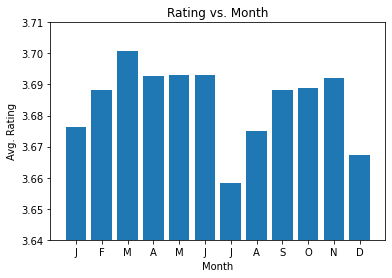

In [ ]:
plt.bar(range(1, 13), [monthAverages[k] for k in range(1, 13)])
months = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
plt.xticks(numpy.arange(1,13,1), months)
plt.ylim(3.64, 3.71)
plt.ylabel("Avg. Rating")
plt.xlabel("Month")
plt.title("Rating vs. Month")


In [ ]:
reviewLength = []
for d in datatimes:
  reviewLength.append(len(d[0]['review_text']))

Text(0.5, 1.0, 'Rating vs. Review Length')

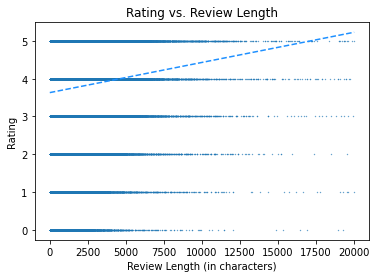

In [ ]:
plt.scatter(reviewLength, ratingSorted, s=0.1)
plt.plot(np.unique(reviewLength), np.poly1d(np.polyfit(reviewLength, ratingSorted, 1))(np.unique(reviewLength)), color = 'dodgerblue', linestyle = '--')
plt.xlabel("Review Length (in characters)")
plt.ylabel("Rating")
plt.title("Rating vs. Review Length")

In [ ]:
comments, votes = [], []
for d in datatimes:
  comments.append(d[0]['n_comments'])
  votes.append(d[0]['n_votes'])

Text(0.5, 1.0, 'Number of Comments vs. Rating')

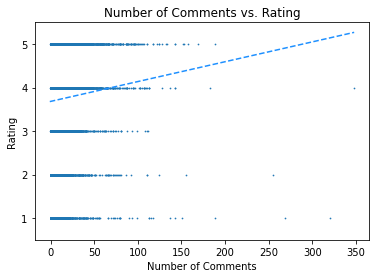

In [ ]:
plt.scatter(comments, ratingSorted, s=0.5)
plt.plot(np.unique(comments), np.poly1d(np.polyfit(comments, ratingSorted, 1))(np.unique(comments)), color = 'dodgerblue', linestyle = '--')
plt.xlabel("Number of Comments")
plt.ylabel("Rating")
plt.ylim(0.5, 5.5)
plt.title("Number of Comments vs. Rating")

Text(0.5, 1.0, 'Number of Votes vs. Rating')

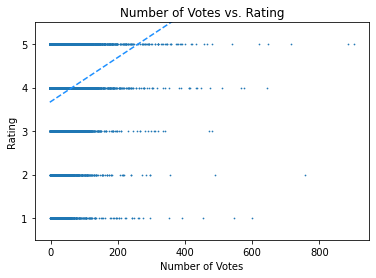

In [ ]:
plt.scatter(votes, ratingSorted, s=0.5)
plt.plot(np.unique(votes), np.poly1d(np.polyfit(votes, ratingSorted, 1))(np.unique(votes)), color = 'dodgerblue', linestyle = '--')
plt.xlabel("Number of Votes")
plt.ylabel("Rating")
plt.ylim(0.5, 5.5)
plt.title("Number of Votes vs. Rating")

In [ ]:
X = numpy.matrix([[1,l] for l in reviewLength]) # Note the inclusion of the constant term
y = numpy.matrix(ratingSorted).T
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta,residuals,rank,s = numpy.linalg.lstsq(X, y, rcond=None)
numpy.linalg.inv(X.T*X)*X.T*y
xplot = numpy.arange(0,20040,10)
yplot = [(theta[0] + theta[1]*x).item() for x in xplot]
plt.scatter(lengths, ratings, color='grey')
plt.plot(numpy.array(xplot), yplot, color = 'k', linestyle = '--',\
         label = r"$3.983 + 1.193 \times 10^{-4} \mathit{length}$")

NameError: ignored